# Load pretraiend model resnet56 from torch.hub

In [3]:
import torch
model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet56", pretrained=True)

Using cache found in /Users/maomao/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


# Load dataset

In [293]:
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torchattacks

use_cuda = True
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]
transform = transforms.Compose(
    [transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
     transforms.Normalize(norm_mean, norm_std),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    for data in testloader:
        images, labels = data

In [294]:
#device = torch.device("cuda:0")
print(device)

cpu


## Test accuracy of the model

In [92]:
st = 100
mt = 400

In [342]:
def test_acc(model, testloader, n_image = 100, show_test_images = False, adv_images = []):
    correct = 0
    total = 0
    p_labels = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            if total == 0:
                test_images = images
            else:
                test_images.add(images)
            if adv_images == []:
                if total % 100 == 0:
                    print("...Testing model on original test images...")
                outputs = model(images)
            else:
                if total % 100 == 0:
                    print("...Testing model on adversarial/perturbed images...")
                outputs = model(adv_images)
            _, predicted = torch.max(outputs.data, 1)
            if total < n_image:
                total += labels.size(0)
                p_labels.append(predicted)
                if show_test_images == True:
                    test_images.add(images)
                else:
                    continue
            else:
                break
            correct += (predicted == labels).sum().item()
            if total % 40 == 0:
                print("Iterations:{} / {} \n Test Accuracy = {} / {} = {}".format(total, n_image,  correct, total, str(correct / total)[:4]))

    test_accuracy = (100.0 * correct / total)
    print('Accuracy of the network on the', total, "images is: ", test_accuracy, '%')
    print("Return test images = ", show_test_images)
    if show_test_images == True:
        return test_accuracy, p_labels, test_images
    else:
        return test_accuracy, p_labels

In [367]:
def test_acc_new(model, testloader, n_image = 100, save_test_images = False):
    correct = 0
    total = 0
    p_labels = []
    for data in testloader:
        images, labels = data
        if save_test_images:
            if total == 0:
                save_images = images
            else:
                save_images.add(images)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        if total < n_image:
            total += labels.size(0)
            p_labels.append(predicted)
        else:
            break
        correct += (predicted == labels).sum().item()
        if total % 40 == 0:
            print("Iterations:{} / {} \n Test Accuracy = {} / {} = {}".format(total, n_image,  correct, total, str(correct / total)[:4]))

    test_accuracy = (100.0 * correct / total)
    print('Accuracy of the network on the', total, "images is: ", test_accuracy, '%')
    print("Saving test images = ", save_test_images)
    if save_test_images == True:
        return test_accuracy, p_labels, save_images
    else:
        return test_accuracy, p_labels

In [369]:
#print(test_accuracy)
#test_accuracy, resnet56_labels, orig = test_acc(model, testloader, mt, True)

In [371]:
test_accuracy, resnet56_labels, orig = test_acc_new(model, testloader, mt, True)

Iterations:40 / 100 
 Test Accuracy = 39 / 40 = 0.97
Iterations:80 / 100 
 Test Accuracy = 76 / 80 = 0.95
Accuracy of the network on the 100 images is:  95.0 %
Saving test images =  False


ValueError: not enough values to unpack (expected 3, got 2)

## FGSM attack

$$\begin{align}perturbed\_image = image + epsilon*sign(data\_grad) = x + \epsilon * sign(\nabla_{x} J(\mathbf{\theta}, \mathbf{x}, y))\end{align}$$

### Examples:

In [ ]:
#attack = torchattacks.FGSM(model, eps)
#adv_images = attack(images, labels)

In [297]:
for data in testloader:
    images, labels = data

### Implement torchattacks.FGSM

In [344]:
test_loader_1=torch.utils.data.DataLoader(testset,batch_size=1,shuffle=True)
epsilons = []
init_eps = 0.003
step = 0.001
n_step = 2
for i in range(n_step):
    epsilons.append(init_eps + i*step)
visual_examples = 5
fgsm_examples = []
accuracies = []

# Run test for each epsilon
for eps in epsilons:
    print("-----------------------------------------------------\n epsilon = ", eps, "\n")
    attack = torchattacks.FGSM(model, eps)
    adv_images = attack(images, labels)
    acc, fgsm_labels , a_images= test_acc(model, testloader, mt, True, adv_images)
    accuracies.append(acc)
    fgsm_examples.append(a_images)

-----------------------------------------------------
 epsilon =  0.003 

...Testing model on adversarial/perturbed images...
Iterations:40 / 400 
 Test Accuracy = 7 / 40 = 0.17
Iterations:80 / 400 
 Test Accuracy = 9 / 80 = 0.11
...Testing model on adversarial/perturbed images...
Iterations:120 / 400 
 Test Accuracy = 11 / 120 = 0.09
Iterations:160 / 400 
 Test Accuracy = 15 / 160 = 0.09
Iterations:200 / 400 
 Test Accuracy = 21 / 200 = 0.10
...Testing model on adversarial/perturbed images...
Iterations:240 / 400 
 Test Accuracy = 29 / 240 = 0.12
Iterations:280 / 400 
 Test Accuracy = 35 / 280 = 0.12
...Testing model on adversarial/perturbed images...
Iterations:320 / 400 
 Test Accuracy = 42 / 320 = 0.13
Iterations:360 / 400 
 Test Accuracy = 48 / 360 = 0.13
Iterations:400 / 400 
 Test Accuracy = 49 / 400 = 0.12
...Testing model on adversarial/perturbed images...
Accuracy of the network on the 400 images is:  12.25 %
Return test images =  True
----------------------------------------

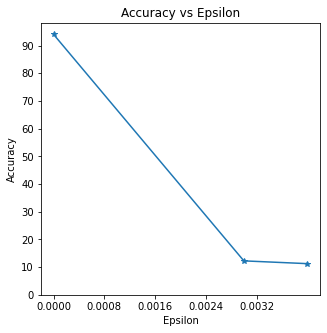

In [345]:
plt.figure(figsize=(5,5))
plt.plot([0] + epsilons, [test_accuracy] + accuracies, "*-")
plt.yticks(np.arange(0.0, test_accuracy, step=10))
plt.xticks(np.arange(0.0, max(epsilons), step=max(epsilons)/5))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

In [285]:
def unnormalize(img, mean = np.array(norm_mean), std = np.array(norm_std)):
    '''
    unnormalize the image that has been normalized with mean and std
    '''
    inverse_mean = - mean/std
    inverse_std = 1/std
    img = transforms.Normalize(mean=-mean/std, std=1/std)(img)
    return img

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def ax_imshow(ax, img, label):
    img = unnormalize(img)     # unnormalize
    img = np.clip(img, 0., 1.)
    ax.set_xticks([])
    ax.set_yticks([])
    img = np.transpose(img, (1,2,0))
    ax.imshow(img)
    ax.set_title(classes[label])

### Check shape match of images and labels

In [223]:
print(orig.shape, adv_ex.shape)
print(len(resnet56_labels))
print(len(fgsm_labels))
#print(resnet56_labels.shape)
print(labels.shape)
print('%5s' % classes[resnet56_labels[i][j]])
print(len(nnoise_labels), noised_img.shape)

torch.Size([4, 3, 32, 32]) torch.Size([3, 32, 32])
100
100
torch.Size([4])
  cat
100 torch.Size([4, 3, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:    cat  ship  ship plane


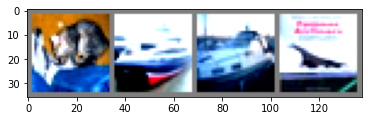

In [346]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(a_images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

<Figure size 144x864 with 0 Axes>

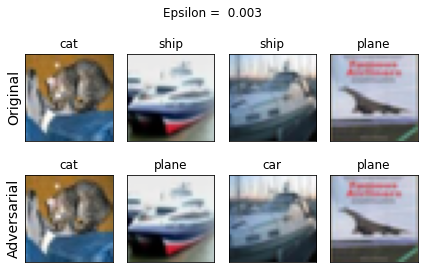

<Figure size 144x864 with 0 Axes>

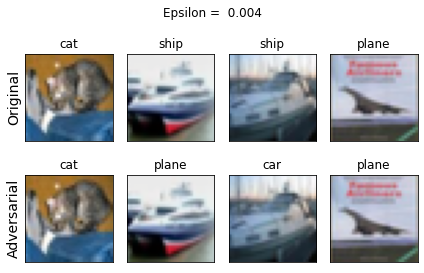

In [347]:
for i,epsilon in enumerate(epsilons):
  plt.figure(figsize=(2,12))
  fig, axs = plt.subplots(2, visual_examples - 1)
  fig.suptitle("Epsilon =  {}".format(epsilon))
  for j in range(len(fgsm_examples[i])): 
    adv_ex = fgsm_examples[i][j]
    ax1 = axs[0, j]
    ax2 = axs[1, j]
    ax_imshow(ax1, orig[j], resnet56_labels[0][j])
    ax_imshow(ax2, adv_ex, fgsm_labels[i][j])
    if j == 0:
      ax1.set_ylabel('Original', fontsize=14)
      ax2.set_ylabel('Adversarial', fontsize=14)
    plt.tight_layout()

# PGD Attack

$$x^{t+1} = \prod_{x+s} (x^t + \alpha sgn(\nabla_xL(\theta,x,y)))$$

In [44]:

import torch.nn as nn
# inspired by https://github.com/Harry24k/PGD-pytorch/blob/master/PGD.ipynb
def pgd_attack(model, image, label, eps, alpha, iters) :

    loss = nn.CrossEntropyLoss()
        
    ori_image = unnormalize(image.data)
        
    for i in range(iters) :    
        image.requires_grad = True
        output = model(image)

        model.zero_grad()
        cost = loss(output, label).to(device)
        cost.backward()

        data_grad = image.grad.data
        image = unnormalize(image)
        adv_image = image + alpha*data_grad.sign()
        eta = adv_image - ori_image
        eta_clip = torch.clamp(eta, min=-eps, max=eps)
        image = torch.clamp(ori_image + eta_clip, min=0, max=1)
        image = transforms.Normalize(mean = norm_mean, std = norm_std)(image).detach()
            
    return image
def pgd_test(model, data_loader, n_examples, eps=0.3, alpha=2/255, iters=7):
  '''
  input: 
    data_loader: data set, batch size = 1
    epsilon: parameter to perform fgsm attack
  return:
    final_acc: accuracy of the model on classifying adversarial examples created based on datas
    adv_examples: n_examples examples of successed adversrial examples
  '''
  correct = 0
  adv_examples = []
  # Loop over all examples in data set, data shape: (C, H, W)
  for i, (data, target) in enumerate(data_loader):

      if i>0 and i%400 == 0:
        current_acc = correct/i
        print(f'Test Accuracy = {current_acc:.4f} [{i:>5d} / {len(data_loader):>5d}]')

      # Send the data and label to the device
      data, target = data.to(device), target.to(device)

      # Forward pass the data through the model
      output = model(data)
      init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
      # If the initial prediction is wrong, dont bother attacking, just move on
      if init_pred.item() != target.item():
          continue

      # Call PGD Attack
      perturbed_data = pgd_attack(model, data, target, eps, alpha, iters)

      # Re-classify the perturbed image
      output = model(perturbed_data)

      # Check for success
      final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
      if final_pred.item() == target.item():
          correct += 1
      else:
          # Save some adv examples for visualization later
          if len(adv_examples) < n_examples:
              adv_ex = perturbed_data.squeeze().detach().cpu()
              ori_ex = data.squeeze().detach().cpu()
              adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex, ori_ex) )
      

  # Calculate final accuracy for this epsilon
  final_acc = correct/float(len(data_loader))
  print("Epsilon: {}, Alpha: {}, Iterations:{} \n Test Accuracy = {} / {} = {}".format(eps,alpha,iters, correct, len(data_loader), final_acc))

  # Return the accuracy and an adversarial example
  return final_acc, adv_examples

In [45]:
acc_pgd, ex_pgd = pgd_test(model, test_loader_1, n_examples = 5)

Test Accuracy = 0.0025 [  400 / 10000]
Test Accuracy = 0.0050 [  800 / 10000]
Test Accuracy = 0.0042 [ 1200 / 10000]
Test Accuracy = 0.0031 [ 1600 / 10000]
Test Accuracy = 0.0030 [ 2000 / 10000]
Test Accuracy = 0.0033 [ 2400 / 10000]
Test Accuracy = 0.0032 [ 2800 / 10000]
Test Accuracy = 0.0031 [ 3200 / 10000]
Test Accuracy = 0.0033 [ 3600 / 10000]
Test Accuracy = 0.0037 [ 4000 / 10000]
Test Accuracy = 0.0041 [ 4400 / 10000]
Test Accuracy = 0.0037 [ 4800 / 10000]
Test Accuracy = 0.0037 [ 5200 / 10000]
Test Accuracy = 0.0036 [ 5600 / 10000]
Test Accuracy = 0.0035 [ 6000 / 10000]
Test Accuracy = 0.0033 [ 6400 / 10000]
Test Accuracy = 0.0032 [ 6800 / 10000]
Test Accuracy = 0.0031 [ 7200 / 10000]
Test Accuracy = 0.0030 [ 7600 / 10000]
Test Accuracy = 0.0031 [ 8000 / 10000]
Test Accuracy = 0.0032 [ 8400 / 10000]
Test Accuracy = 0.0033 [ 8800 / 10000]
Test Accuracy = 0.0033 [ 9200 / 10000]
Test Accuracy = 0.0031 [ 9600 / 10000]
Epsilon: 0.3, Alpha: 0.00784313725490196, Iterations:7 
 Test Ac

<Figure size 144x864 with 0 Axes>

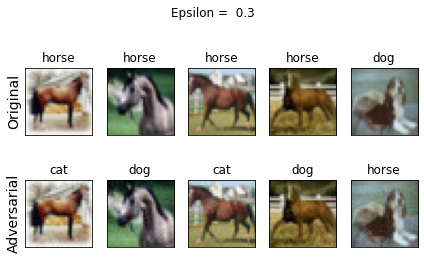

In [46]:
plt.figure(figsize=(2,12))
fig, axs = plt.subplots(2, 5)
fig.suptitle("Epsilon =  {}".format(0.3))
for j in range(len(ex_pgd)): 
  orig,adv,adv_ex,ori_ex = ex_pgd[j]
  ax1 = axs[0, j]
  ax2 = axs[1, j]
  ax_imshow(ax2, adv_ex, adv)
  ax_imshow(ax1, ori_ex, orig)
  if j == 0:
    ax1.set_ylabel('Original', fontsize=14)
    ax2.set_ylabel('Adversarial', fontsize=14)
  plt.tight_layout()

# Random Natural Noise

## Add Random Natural Noise to original images

In [306]:
def add_noise(image, eps = 0.3) :
 
    noise = torch.randn(1, 3, 32, 32)
    #print(noise)
    data_noise = noise

    image = torch.clamp(image + data_noise, min=image - eps, max=image + eps)
    #image = torch.clamp(image, min = 0, max = 1)
            
    return image

In [330]:
epsilons_n = [100]
for eps2 in epsilons_n:
    noised_img = add_noise(images, eps2)
    test_accuracy_n, nnoise_labels, noised_img = test_acc(model, testloader, mt, True, noised_img)

...Testing model on adversarial/perturbed images...
Iterations:40 / 400 
 Test Accuracy = 3 / 40 = 0.07
Iterations:80 / 400 
 Test Accuracy = 7 / 80 = 0.08
...Testing model on adversarial/perturbed images...
Iterations:120 / 400 
 Test Accuracy = 10 / 120 = 0.08
Iterations:160 / 400 
 Test Accuracy = 18 / 160 = 0.11
Iterations:200 / 400 
 Test Accuracy = 23 / 200 = 0.11
...Testing model on adversarial/perturbed images...
Iterations:240 / 400 
 Test Accuracy = 25 / 240 = 0.10
Iterations:280 / 400 
 Test Accuracy = 27 / 280 = 0.09
...Testing model on adversarial/perturbed images...
Iterations:320 / 400 
 Test Accuracy = 31 / 320 = 0.09
Iterations:360 / 400 
 Test Accuracy = 35 / 360 = 0.09
Iterations:400 / 400 
 Test Accuracy = 41 / 400 = 0.10
...Testing model on adversarial/perturbed images...
Accuracy of the network on the 400 images is:  10.25 %
Return test images =  True


<Figure size 144x864 with 0 Axes>

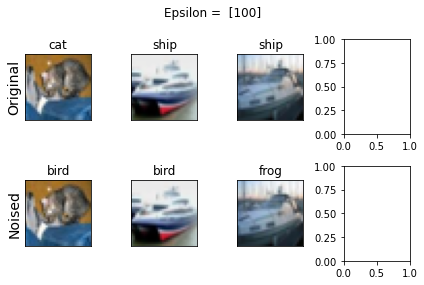

In [335]:
plt.figure(figsize=(2,12))
fig, axs = plt.subplots(2, visual_examples - 1)
fig.suptitle("Epsilon =  {}".format(epsilons_n))
for j in range(len(noised_img[0])): 
    ax1 = axs[0, j]
    ax2 = axs[1, j]
    ax_imshow(ax1, orig[j], resnet56_labels[0][j])
    ax_imshow(ax2, noised_img[j], nnoise_labels[0][j])
    if j == 0:
          ax1.set_ylabel('Original', fontsize=14)
          ax2.set_ylabel('Noised', fontsize=14)
plt.tight_layout()

## Add Random Natural Noise to perturbed images

In [ ]:
def pgd_noise_test(model, data_loader, n_examples, eps=0.3, alpha=2/255, iters=7):
  '''
  input: 
    data_loader: data set, batch size = 1
    epsilon: parameter to perform fgsm attack
  return:
    final_acc: accuracy of the model on classifying adversarial examples created based on datas
    adv_examples: n_examples examples of successed adversrial examples
  '''
  print("eps = ", eps)
  correct = 0
  adv_examples = []
  # Loop over all examples in data set, data shape: (C, H, W)
  for i, (data, target) in enumerate(data_loader):

      if i>0 and i%400 == 0:
        current_acc = correct/i
        print(f'Test Accuracy = {current_acc:.4f} [{i:>5d} / {len(data_loader):>5d}]')

      # Send the data and label to the device
      data, target = data.to(device), target.to(device)

      # Forward pass the data through the model
      output = model(data)
      init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
      # If the initial prediction is wrong, dont bother attacking, just move on
      if init_pred.item() != target.item():
          continue

      # Call PGD Attack
      perturbed_data = add_noise(model,pgd_attack(model, data, target, eps, alpha, iters),target, 1, 1)

      # Re-classify the perturbed image
      output = model(perturbed_data)

      # Check for success
      final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
      if final_pred.item() == target.item():
          correct += 1
      else:
          # Save some adv examples for visualization later
          if len(adv_examples) < n_examples:
              adv_ex = perturbed_data.squeeze().detach().cpu()
              ori_ex = data.squeeze().detach().cpu()
              adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex, ori_ex) )
      
  print("eps = ", eps)
  # Calculate final accuracy for this epsilon
  final_acc = correct/float(len(data_loader))
  print("Epsilon: {}, Alpha: {}, Iterations:{} \n Test Accuracy = {} / {} = {}".format(eps,alpha,iters, correct, len(data_loader), final_acc))

  # Return the accuracy and an adversarial example
  return final_acc, adv_examples

In [63]:
acc_pgd_n, ex_pgd_n = pgd_noise_test(model, test_loader_1, n_examples = 5)

Test Accuracy = 0.0800 [  400 / 10000]
Test Accuracy = 0.0800 [  800 / 10000]
Test Accuracy = 0.0825 [ 1200 / 10000]
Test Accuracy = 0.0794 [ 1600 / 10000]
Test Accuracy = 0.0820 [ 2000 / 10000]
Test Accuracy = 0.0867 [ 2400 / 10000]
Test Accuracy = 0.0836 [ 2800 / 10000]
Test Accuracy = 0.0809 [ 3200 / 10000]
Test Accuracy = 0.0811 [ 3600 / 10000]
Test Accuracy = 0.0828 [ 4000 / 10000]
Test Accuracy = 0.0830 [ 4400 / 10000]
Test Accuracy = 0.0831 [ 4800 / 10000]
Test Accuracy = 0.0827 [ 5200 / 10000]
Test Accuracy = 0.0818 [ 5600 / 10000]
Test Accuracy = 0.0820 [ 6000 / 10000]
Test Accuracy = 0.0822 [ 6400 / 10000]
Test Accuracy = 0.0822 [ 6800 / 10000]
Test Accuracy = 0.0815 [ 7200 / 10000]
Test Accuracy = 0.0804 [ 7600 / 10000]
Test Accuracy = 0.0800 [ 8000 / 10000]
Test Accuracy = 0.0798 [ 8400 / 10000]
Test Accuracy = 0.0799 [ 8800 / 10000]
Test Accuracy = 0.0801 [ 9200 / 10000]
Test Accuracy = 0.0801 [ 9600 / 10000]
Epsilon: 0.3, Alpha: 0.00784313725490196, Iterations:7 
 Test Ac

ValueError: too many values to unpack (expected 4)

<Figure size 144x864 with 0 Axes>

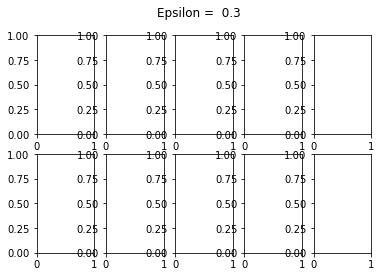

In [94]:
plt.figure(figsize=(2,12))
fig, axs = plt.subplots(2, 5)
fig.suptitle("Epsilon =  {}".format(0.3))
for j in range(len(ex_pgd)): 
  orig,acc_pgd_n,ex_pgd_n,ori_ex = ex_pgd[j]
  ax1 = axs[0, j]
  ax2 = axs[1, j]
  ax_imshow(ax2, ex_pgd_n, acc_pgd_n)
  ax_imshow(ax1, ori_ex, orig)
  if j == 0:
    ax1.set_ylabel('Original', fontsize=14)
    ax2.set_ylabel('Adversarial', fontsize=14)
  plt.tight_layout()

In [103]:
epsilons_n= []
e = 0.001
for i in range(10):
    e += 0.0001
    epsilons_n.append(e)
n_examples = 5
examples_n = []
accuracies_n = []

# Run test for each epsilon
for eps in epsilons_n:
    print('eps = ', eps)
    acc_n, ex_n = pgd_noise_test(model, test_loader_1, eps, n_examples)
    accuracies_n.append(acc_n)
    examples_n.append(ex_n)

eps =  0.0011
Test Accuracy = 0.0775 [  400 / 10000]
Test Accuracy = 0.0712 [  800 / 10000]
Test Accuracy = 0.0700 [ 1200 / 10000]
Test Accuracy = 0.0663 [ 1600 / 10000]
Test Accuracy = 0.0685 [ 2000 / 10000]
Test Accuracy = 0.0683 [ 2400 / 10000]
Test Accuracy = 0.0707 [ 2800 / 10000]
Test Accuracy = 0.0725 [ 3200 / 10000]


KeyboardInterrupt: 

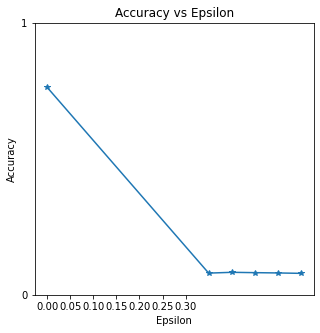

In [98]:
plt.figure(figsize=(5,5))
plt.plot([0] + epsilons, [test_accuracy/100] + accuracies_n, "*-")
plt.yticks(np.arange(0.0, 1.1, step=1))
plt.xticks(np.arange(0.0, .0011, step=0.0001))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

<Figure size 144x864 with 0 Axes>

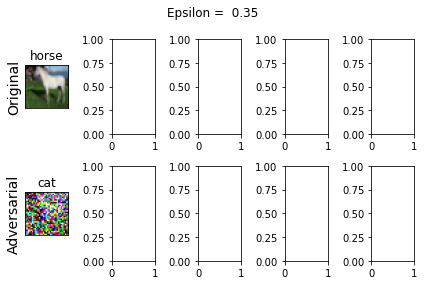

<Figure size 144x864 with 0 Axes>

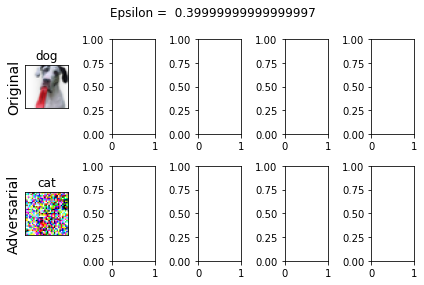

<Figure size 144x864 with 0 Axes>

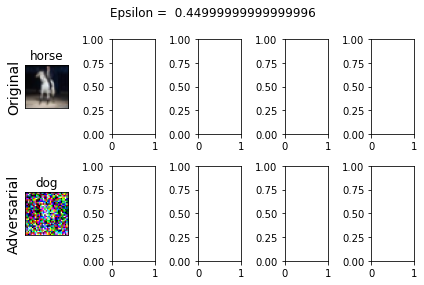

<Figure size 144x864 with 0 Axes>

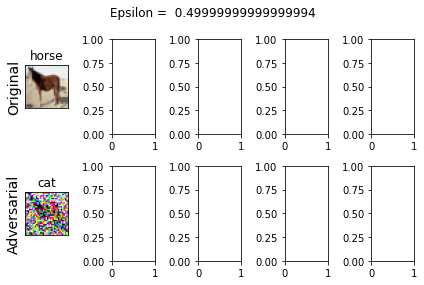

<Figure size 144x864 with 0 Axes>

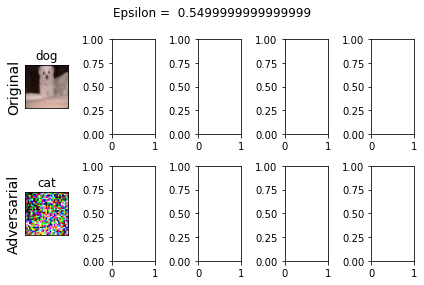

In [102]:
def ax_imshow(ax, img, label):
    img = unnormalize(img)     # unnormalize
    img = np.clip(img, 0., 1.)
    ax.set_xticks([])
    ax.set_yticks([])
    img = np.transpose(img, (1,2,0))
    ax.imshow(img)
    ax.set_title(classes[label])


for i,epsilon in enumerate(epsilons):
  plt.figure(figsize=(2,12))
  fig, axs = plt.subplots(2, n_examples)
  fig.suptitle("Epsilon =  {}".format(epsilon))
  for j in range(len(examples_n[i])): 
    orig,adv,adv_ex,ori_ex = examples_n[i][j]
    ax1 = axs[0, j]
    ax2 = axs[1, j]
    ax_imshow(ax2, adv_ex, adv)
    ax_imshow(ax1, ori_ex, orig)
    if j == 0:
      ax1.set_ylabel('Original', fontsize=14)
      ax2.set_ylabel('Adversarial', fontsize=14)
    plt.tight_layout()

IndexError: list index out of range

<Figure size 144x864 with 0 Axes>

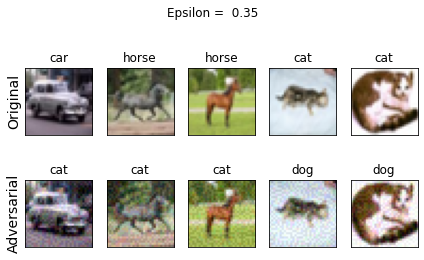

In [89]:
def ax_imshow(ax, img, label):
    img = unnormalize(img)     # unnormalize
    img = np.clip(img, 0., 1.)
    ax.set_xticks([])
    ax.set_yticks([])
    img = np.transpose(img, (1,2,0))
    ax.imshow(img)
    ax.set_title(classes[label])


for i,epsilon in enumerate(epsilons_n):
  plt.figure(figsize=(2,12))
  fig, axs = plt.subplots(2, n_examples)
  fig.suptitle("Epsilon =  {}".format(epsilon))
  for j in range(len(examples[i])+1): 
    orig,noise,noise_ex,ori_ex = examples[i][j]
    ax1 = axs[0, j]
    ax2 = axs[1, j]
    ax_imshow(ax2, noise_ex, noise)
    ax_imshow(ax1, ori_ex, orig)
    if j == 0:
      ax1.set_ylabel('Original', fontsize=14)
      ax2.set_ylabel('Adversarial', fontsize=14)
    plt.tight_layout()